In [1]:
!pip install numpy pandas matplotlib seaborn scikit-learn imbalanced-learn

SETTING UP PATHS
Base Directory: C:\Users\dmitr\Desktop\Stock-Market-Crash-Predictor
Data File: C:\Users\dmitr\Desktop\Stock-Market-Crash-Predictor\data\merged\merged_dataset_cleaned.csv
Output Directory: C:\Users\dmitr\Desktop\Stock-Market-Crash-Predictor\output
Models Directory: C:\Users\dmitr\Desktop\Stock-Market-Crash-Predictor\output\models
Plots Directory: C:\Users\dmitr\Desktop\Stock-Market-Crash-Predictor\output\plots
✓ Data file found!

LOADING MERGED DATASET
Loaded dataset shape: (9052, 36)
Date range: 1990-01-02 00:00:00 to 2025-12-09 00:00:00

Columns in dataset:
['date', 'close_sp500', 'high_sp500', 'low_sp500', 'open_sp500', 'volume_sp500', 'close_vix', 'high_vix', 'low_vix', 'open_vix', 'volume_vix', 'cpi', 'unemployment', 'fed_funds_rate', 'm2_money_stock', 'home_prices_case_shiller', 'housing_starts', 'building_permits', 'mortgage_30y', 't10y', 't2y', 't3m', 'real_10y', 'breakeven_10y', 'cpi_core', 'pce_headline', 'pce_core', 'initial_claims', 'continuing_claims', 'umi

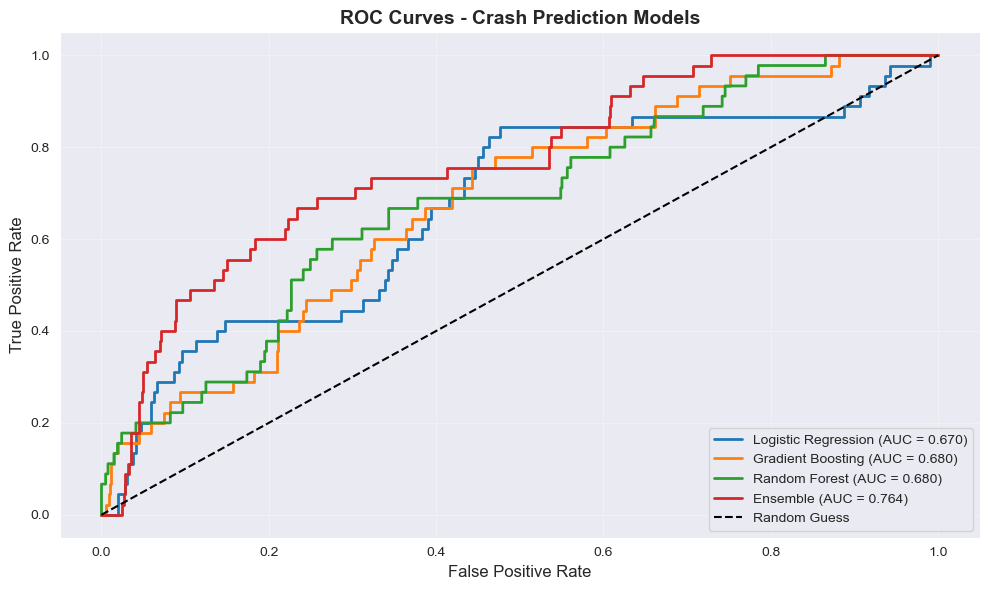

✓ ROC curves saved to C:\Users\dmitr\Desktop\Stock-Market-Crash-Predictor\output\plots\roc_curves.png


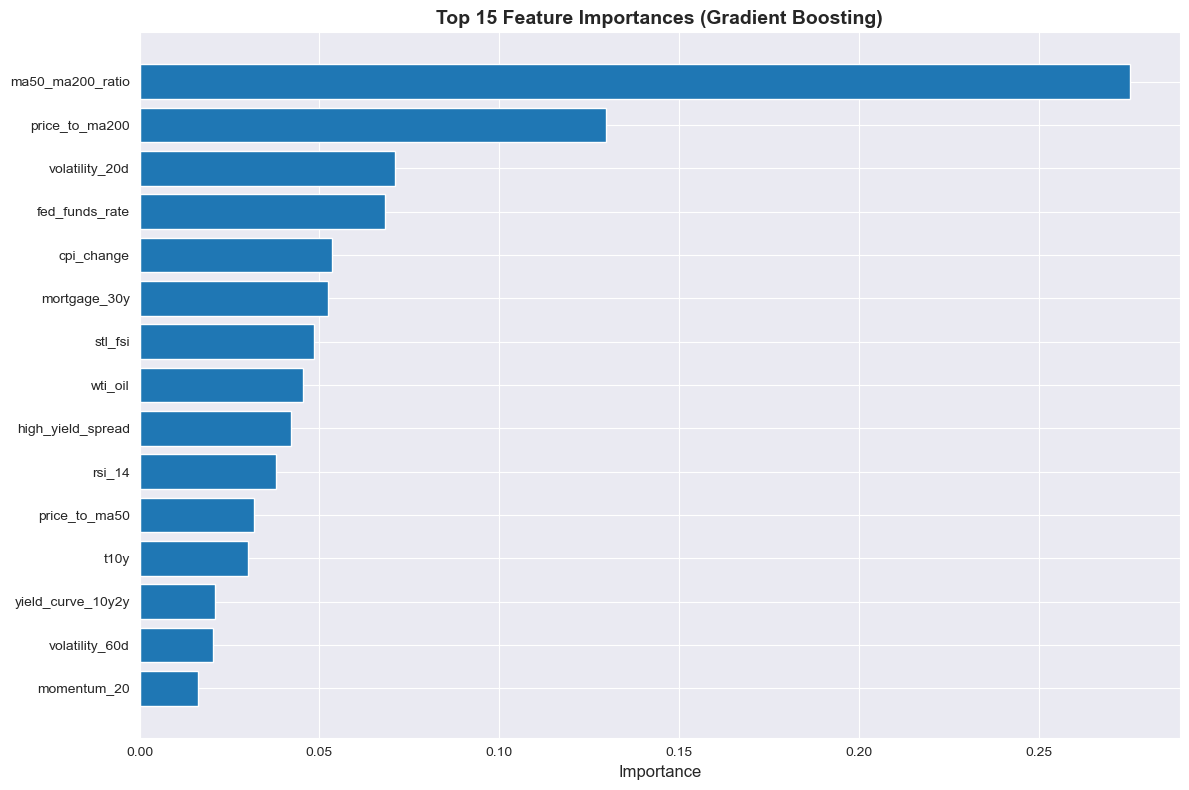

✓ Feature importance plot saved to C:\Users\dmitr\Desktop\Stock-Market-Crash-Predictor\output\plots\feature_importance.png


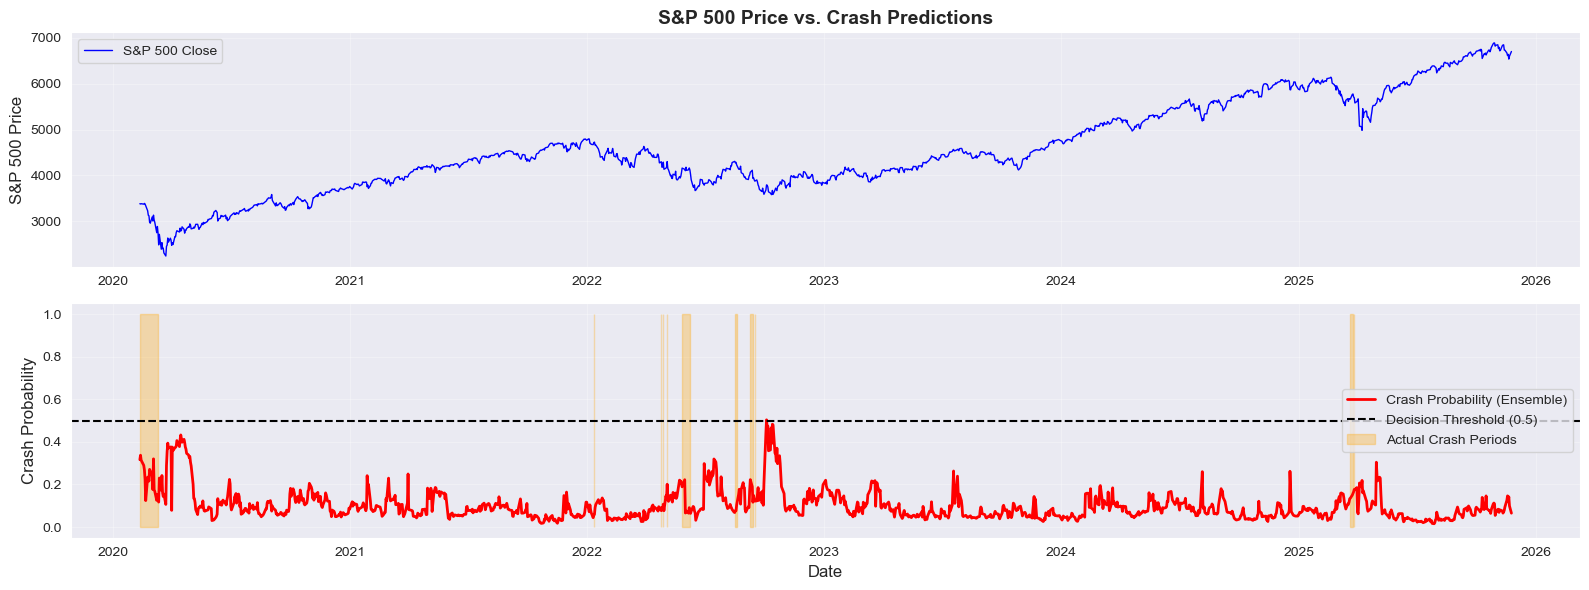

✓ Prediction timeline saved to C:\Users\dmitr\Desktop\Stock-Market-Crash-Predictor\output\plots\prediction_timeline.png

BACKTESTING ON HISTORICAL CRASHES

2000 Dot-com Crash: Period not in test set

2008 Financial Crisis: Period not in test set

2020 COVID Crash:
  Average crash probability: 22.93%
  Maximum crash probability: 39.40%
  Days above 50% threshold: 0/31

SAVING RESULTS
✓ Results saved to C:\Users\dmitr\Desktop\Stock-Market-Crash-Predictor\output\crash_predictions.csv
✓ Models saved to C:\Users\dmitr\Desktop\Stock-Market-Crash-Predictor\output\models

PREDICTION PIPELINE COMPLETE

Key outputs:
  - ROC curves: C:\Users\dmitr\Desktop\Stock-Market-Crash-Predictor\output\plots\roc_curves.png
  - Feature importance: C:\Users\dmitr\Desktop\Stock-Market-Crash-Predictor\output\plots\feature_importance.png
  - Prediction timeline: C:\Users\dmitr\Desktop\Stock-Market-Crash-Predictor\output\plots\prediction_timeline.png
  - Results CSV: C:\Users\dmitr\Desktop\Stock-Market-Crash-Predi

In [6]:
# ============================================================================
# PREDICTIVE MODELING FOR STOCK MARKET CRASH DETECTION
# ============================================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, f1_score
)
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

# Set styling for plots
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)

# ============================================================================
# STEP 0: DEFINE PATHS
# ============================================================================

print("=" * 80)
print("SETTING UP PATHS")
print("=" * 80)

# Define base directory and data paths
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, 'data')
MERGED_DIR = os.path.join(DATA_DIR, 'merged')
MERGED_FILE = os.path.join(MERGED_DIR, 'merged_dataset_cleaned.csv')

# Create output directories
OUTPUT_DIR = os.path.join(BASE_DIR, 'output')
MODELS_DIR = os.path.join(OUTPUT_DIR, 'models')
PLOTS_DIR = os.path.join(OUTPUT_DIR, 'plots')

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

print(f"Base Directory: {BASE_DIR}")
print(f"Data File: {MERGED_FILE}")
print(f"Output Directory: {OUTPUT_DIR}")
print(f"Models Directory: {MODELS_DIR}")
print(f"Plots Directory: {PLOTS_DIR}")

# Check if file exists
if not os.path.exists(MERGED_FILE):
    print(f"\n⚠️  ERROR: File not found at {MERGED_FILE}")
    print("Please ensure the file exists at: Stock-Market-Crash-Predictor/data/merged/merged_dataset_cleaned.csv")
    exit(1)
else:
    print(f"✓ Data file found!")

# ============================================================================
# STEP 1: LOAD THE MERGED DATASET
# ============================================================================

print("\n" + "=" * 80)
print("LOADING MERGED DATASET")
print("=" * 80)

df = pd.read_csv(MERGED_FILE)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

print(f"Loaded dataset shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nColumns in dataset:")
print(df.columns.tolist())
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData types:")
print(df.dtypes)
print(f"\nMissing values:")
print(df.isnull().sum())

# ============================================================================
# STEP 2: DEFINE CRASH EVENTS
# ============================================================================

print("\n" + "=" * 80)
print("DEFINING CRASH EVENTS")
print("=" * 80)

# Calculate returns (% change in S&P 500 close)
df['sp500_return'] = df['close_sp500'].pct_change()

print(f"Sample S&P 500 returns:")
print(df[['date', 'close_sp500', 'sp500_return']].head(20))

# Try multiple crash thresholds to see which works
thresholds_to_test = [
    (-0.10, "10% drop"),
    (-0.07, "7% drop"),
    (-0.05, "5% drop"),
    (-0.03, "3% drop")
]

print("\nTesting different crash thresholds:")
crash_counts = {}

for threshold, label in thresholds_to_test:
    def detect_crash_forward(df, window=10, threshold=threshold):
        """
        Detect if a crash occurs in the next `window` days
        """
        crashes = []
        crash_details = []
        
        for i in range(len(df)):
            if i + window >= len(df):
                crashes.append(np.nan)
                continue
            
            future_returns = df['sp500_return'].iloc[i+1:i+1+window]
            cumulative_return = (1 + future_returns).prod() - 1
            
            if cumulative_return <= threshold:
                crashes.append(1)
                if len(crash_details) < 5:  # Store first 5 for display
                    crash_details.append({
                        'date': df['date'].iloc[i],
                        'cumulative_return': cumulative_return
                    })
            else:
                crashes.append(0)
        
        return crashes, crash_details
    
    crashes, details = detect_crash_forward(df, window=10, threshold=threshold)
    df_temp = df.copy()
    df_temp['crash_temp'] = crashes
    df_temp = df_temp[df_temp['crash_temp'].notna()]
    crash_count = df_temp['crash_temp'].sum()
    crash_counts[threshold] = crash_count
    
    print(f"  {label}: {int(crash_count)} events ({crash_count/len(df_temp)*100:.2f}%)")
    if len(details) > 0 and crash_count > 0:
        print(f"    Sample events: {details[0]['date'].strftime('%Y-%m-%d')} ({details[0]['cumulative_return']:.2%})")

# Choose threshold that gives reasonable number of crashes (aim for 2-10%)
best_threshold = -0.05  # Default to 5%
for threshold, count in crash_counts.items():
    crash_rate = count / len(df) * 100
    if 1 <= crash_rate <= 15:  # Between 1% and 15% crash rate
        best_threshold = threshold
        break

print(f"\n✓ Selected threshold: {best_threshold*100:.0f}% drop ({crash_counts[best_threshold]:.0f} events)")

# Define crash detection function with chosen threshold
def detect_crash_forward(df, window=10, threshold=best_threshold):
    """
    Detect if a crash (threshold drop) occurs in the next `window` days
    """
    crashes = []
    crash_details = []
    
    for i in range(len(df)):
        if i + window >= len(df):
            crashes.append(np.nan)
            continue
        
        future_returns = df['sp500_return'].iloc[i+1:i+1+window]
        cumulative_return = (1 + future_returns).prod() - 1
        
        if cumulative_return <= threshold:
            crashes.append(1)
            crash_details.append({
                'date': df['date'].iloc[i],
                'cumulative_return': cumulative_return
            })
        else:
            crashes.append(0)
    
    return crashes, crash_details

# Create crash target variable
df['crash_10d'], crash_details = detect_crash_forward(df, window=10, threshold=best_threshold)

# Drop rows where we can't calculate crash (last 10 days)
df_model = df[df['crash_10d'].notna()].copy()

print(f"\nTotal crash events detected: {int(df_model['crash_10d'].sum())}")
print(f"Crash rate: {df_model['crash_10d'].mean():.2%}")
print(f"Non-crash events: {(df_model['crash_10d'] == 0).sum()}")

if len(crash_details) > 0:
    print(f"\nSample crash events detected:")
    for i, detail in enumerate(crash_details[:10]):
        print(f"  {i+1}. {detail['date'].strftime('%Y-%m-%d')}: {detail['cumulative_return']:.2%} drop")
else:
    print("\n⚠️  WARNING: No crash events detected!")
    print("   Your data may not include volatile periods.")

# ============================================================================
# HELPER FUNCTION: RSI CALCULATION
# ============================================================================

def compute_rsi(series, window=14):
    """
    Compute Relative Strength Index (RSI)
    """
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# ============================================================================
# STEP 3: FEATURE ENGINEERING
# ============================================================================

print("\n" + "=" * 80)
print("FEATURE ENGINEERING")
print("=" * 80)

# Moving averages for S&P 500 (using min_periods to reduce NaN)
df_model['ma_20'] = df_model['close_sp500'].rolling(20, min_periods=10).mean()
df_model['ma_50'] = df_model['close_sp500'].rolling(50, min_periods=25).mean()
df_model['ma_200'] = df_model['close_sp500'].rolling(200, min_periods=100).mean()

# Price relative to moving averages
df_model['price_to_ma20'] = df_model['close_sp500'] / df_model['ma_20']
df_model['price_to_ma50'] = df_model['close_sp500'] / df_model['ma_50']
df_model['price_to_ma200'] = df_model['close_sp500'] / df_model['ma_200']

# Moving average crossovers (golden cross / death cross signals)
df_model['ma50_ma200_ratio'] = df_model['ma_50'] / df_model['ma_200']

# Volatility features
df_model['volatility_20d'] = df_model['sp500_return'].rolling(20, min_periods=10).std()
df_model['volatility_60d'] = df_model['sp500_return'].rolling(60, min_periods=30).std()

# VIX features (check if VIX column exists)
if 'close_vix' in df_model.columns:
    df_model['vix_ma_10'] = df_model['close_vix'].rolling(10, min_periods=5).mean()
    df_model['vix_spike'] = df_model['close_vix'] / df_model['vix_ma_10']
else:
    print("⚠️  VIX data not found in dataset")

# Yield curve features (check if columns exist)
if 't10y' in df_model.columns and 't2y' in df_model.columns:
    df_model['yield_curve_10y2y'] = df_model['t10y'] - df_model['t2y']
if 't10y' in df_model.columns and 't3m' in df_model.columns:
    df_model['yield_curve_10y3m'] = df_model['t10y'] - df_model['t3m']

# Change in key macro indicators (month-over-month)
if 'cpi' in df_model.columns:
    df_model['cpi_change'] = df_model['cpi'].pct_change(periods=20)  # ~1 month

if 'unemployment' in df_model.columns:
    df_model['unemployment_change'] = df_model['unemployment'].diff()

if 'fed_funds_rate' in df_model.columns:
    df_model['fed_rate_change'] = df_model['fed_funds_rate'].diff()

# Financial stress indicators
if 'high_yield_spread' in df_model.columns:
    df_model['high_yield_spread_ma'] = df_model['high_yield_spread'].rolling(20, min_periods=10).mean()

# Momentum indicators
df_model['rsi_14'] = compute_rsi(df_model['close_sp500'], window=14)
df_model['momentum_20'] = df_model['close_sp500'].pct_change(periods=20)

print("✓ Feature engineering complete")

# Count features created
new_features = [c for c in df_model.columns if c not in df.columns]
print(f"✓ Total features created: {len(new_features)}")
print(f"✓ New features: {new_features[:10]}..." if len(new_features) > 10 else f"✓ New features: {new_features}")

# ============================================================================
# STEP 4: PREPARE MODELING DATASET
# ============================================================================

print("\n" + "=" * 80)
print("PREPARING MODELING DATASET")
print("=" * 80)

# First, let's check what we have after feature engineering
print(f"Dataset shape after feature engineering: {df_model.shape}")
print(f"\nChecking for NaN values in key features:")
key_features_check = ['price_to_ma20', 'volatility_20d', 'close_vix', 'yield_curve_10y2y', 
                      'rsi_14', 'cpi_change', 'unemployment', 'crash_10d']
for feat in key_features_check:
    if feat in df_model.columns:
        nan_count = df_model[feat].isna().sum()
        nan_pct = (nan_count / len(df_model)) * 100
        print(f"  {feat}: {nan_count} NaN ({nan_pct:.1f}%)")

# Select features for modeling
feature_cols = [
    # Price-based features
    'price_to_ma20', 'price_to_ma50', 'price_to_ma200', 'ma50_ma200_ratio',
    
    # Volatility
    'volatility_20d', 'volatility_60d', 'close_vix', 'vix_spike',
    
    # Rates & yield curve
    'yield_curve_10y2y', 'yield_curve_10y3m', 't10y', 'fed_funds_rate', 'fed_rate_change',
    
    # Macro
    'cpi_change', 'unemployment', 'unemployment_change',
    
    # Financial stress
    'high_yield_spread', 'stl_fsi',
    
    # Momentum
    'rsi_14', 'momentum_20',
    
    # Additional macro
    'mortgage_30y', 'initial_claims', 'wti_oil'
]

# Check which features are available and have data
available_features = []
missing_features = []
for f in feature_cols:
    if f in df_model.columns:
        # Check if feature has any non-NaN values
        if df_model[f].notna().any():
            available_features.append(f)
        else:
            print(f"  ⚠️  Feature '{f}' exists but is all NaN")
    else:
        missing_features.append(f)

if missing_features:
    print(f"\n⚠️  Warning: The following features are missing from the dataset:")
    for f in missing_features:
        print(f"  - {f}")

if len(available_features) == 0:
    print("\n⚠️  CRITICAL ERROR: No valid features available!")
    print("   This means the dataset is missing required columns.")
    print(f"\n   Available columns in dataset: {df_model.columns.tolist()}")
    exit(1)

print(f"\n✓ Using {len(available_features)} available features")
feature_cols = available_features

# Check how many rows we'll lose when dropping NaN
print(f"\nBefore dropping NaN:")
print(f"  Total rows: {len(df_model)}")

# Drop rows with NaN (from rolling windows)
df_clean = df_model.dropna(subset=feature_cols + ['crash_10d'])

print(f"\nAfter dropping NaN:")
print(f"  Remaining rows: {len(df_clean)}")
print(f"  Rows dropped: {len(df_model) - len(df_clean)}")

if len(df_clean) == 0:
    print("\n⚠️  CRITICAL ERROR: All rows were dropped due to NaN values!")
    print("   This is usually because:")
    print("     1. The rolling windows (200 days) are too large for your dataset")
    print("     2. The original data has too many missing values")
    print("\n   Attempting to use smaller rolling windows...")
    
    # Recalculate features with smaller windows
    df_model['ma_20'] = df_model['close_sp500'].rolling(20, min_periods=10).mean()
    df_model['ma_50'] = df_model['close_sp500'].rolling(50, min_periods=25).mean()
    df_model['ma_100'] = df_model['close_sp500'].rolling(100, min_periods=50).mean()
    df_model['price_to_ma20'] = df_model['close_sp500'] / df_model['ma_20']
    df_model['price_to_ma50'] = df_model['close_sp500'] / df_model['ma_50']
    df_model['price_to_ma100'] = df_model['close_sp500'] / df_model['ma_100']
    df_model['ma50_ma100_ratio'] = df_model['ma_50'] / df_model['ma_100']
    df_model['volatility_20d'] = df_model['sp500_return'].rolling(20, min_periods=10).std()
    df_model['rsi_14'] = compute_rsi(df_model['close_sp500'], window=14)
    
    # Use simpler feature set
    feature_cols = ['price_to_ma20', 'price_to_ma50', 'volatility_20d', 'close_vix']
    feature_cols = [f for f in feature_cols if f in df_model.columns and df_model[f].notna().any()]
    
    df_clean = df_model.dropna(subset=feature_cols + ['crash_10d'])
    print(f"\n   After using smaller windows: {len(df_clean)} rows")
    
    if len(df_clean) == 0:
        print("\n⚠️  CRITICAL ERROR: Still no valid data!")
        print("   Your dataset likely doesn't have enough consecutive data points.")
        print(f"\n   Please check: {MERGED_FILE}")
        exit(1)

df_model = df_clean
X = df_model[feature_cols]
y = df_model['crash_10d']
dates = df_model['date']

print(f"\n✓ Final modeling dataset shape: {X.shape}")
print(f"✓ Features used: {len(feature_cols)}")
print(f"✓ Feature list: {feature_cols}")
print(f"✓ Crash events: {int(y.sum())} ({y.mean():.2%})")
print(f"✓ Date range: {dates.min()} to {dates.max()}")

# ============================================================================
# STEP 5: TRAIN/TEST SPLIT (TIME-BASED)
# ============================================================================

print("\n" + "=" * 80)
print("TRAIN/TEST SPLIT")
print("=" * 80)

# Check if we have enough data
if len(df_model) < 100:
    print(f"⚠️  ERROR: Insufficient data after feature engineering!")
    print(f"   Total samples: {len(df_model)}")
    print(f"   This might be due to:")
    print(f"     1. Too many NaN values from rolling windows (need 200+ days)")
    print(f"     2. Missing columns in the dataset")
    print(f"     3. Insufficient raw data")
    print(f"\n   Try reducing the window sizes or checking your data source.")
    exit(1)

# Use 80% for training, 20% for testing (time-based, no shuffling)
split_date = df_model['date'].quantile(0.8)
train_mask = df_model['date'] < split_date
test_mask = df_model['date'] >= split_date

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]
dates_train = dates[train_mask]
dates_test = dates[test_mask]

print(f"Training set: {X_train.shape[0]} samples ({dates_train.min()} to {dates_train.max()})")
print(f"Test set: {X_test.shape[0]} samples ({dates_test.min()} to {dates_test.max()})")

if len(y_train) > 0:
    print(f"Train crash rate: {y_train.mean():.2%}")
else:
    print("⚠️  WARNING: No training samples!")
    
if len(y_test) > 0:
    print(f"Test crash rate: {y_test.mean():.2%}")
else:
    print("⚠️  WARNING: No test samples!")

# Check if we have valid training data
if len(X_train) == 0:
    print("\n⚠️  ERROR: Training set is empty!")
    print("   This usually means the split removed all valid data.")
    print("   Adjusting split to 70/30 to ensure we have training data...")
    
    # Try a different split
    split_date = df_model['date'].quantile(0.7)
    train_mask = df_model['date'] < split_date
    test_mask = df_model['date'] >= split_date
    
    X_train = X[train_mask]
    X_test = X[test_mask]
    y_train = y[train_mask]
    y_test = y[test_mask]
    dates_train = dates[train_mask]
    dates_test = dates[test_mask]
    
    print(f"\n   New training set: {X_train.shape[0]} samples")
    print(f"   New test set: {X_test.shape[0]} samples")
    
    if len(X_train) == 0:
        print("\n⚠️  CRITICAL ERROR: Still no training data after adjustment!")
        print("   Cannot proceed with model training.")
        exit(1)

# ============================================================================
# STEP 6: HANDLE CLASS IMBALANCE
# ============================================================================

print("\n" + "=" * 80)
print("HANDLING CLASS IMBALANCE")
print("=" * 80)

# Separate majority and minority classes
X_train_majority = X_train[y_train == 0]
X_train_minority = X_train[y_train == 1]
y_train_majority = y_train[y_train == 0]
y_train_minority = y_train[y_train == 1]

print(f"Before resampling:")
print(f"  Majority class: {len(X_train_majority)}")
print(f"  Minority class: {len(X_train_minority)}")

# Check if we have any minority samples
if len(X_train_minority) == 0:
    print("\n⚠️  WARNING: No crash events in training set!")
    print("  The model may not learn to predict crashes effectively.")
    print("  Consider:")
    print("    1. Adjusting the crash threshold (currently 10% drop)")
    print("    2. Using a longer time window")
    print("    3. Getting more historical data")
    
    # Use original training data without resampling
    X_train_balanced = X_train
    y_train_balanced = y_train
    
elif len(X_train_minority) < 10:
    print(f"\n⚠️  WARNING: Very few crash events ({len(X_train_minority)}) in training set!")
    print("  Using aggressive oversampling to create balanced dataset.")
    
    # Oversample minority to match majority
    n_samples_target = max(len(X_train_majority), len(X_train_minority) * 10)
    X_train_minority_upsampled = resample(
        X_train_minority,
        replace=True,
        n_samples=n_samples_target,
        random_state=42
    )
    y_train_minority_upsampled = pd.Series([1] * len(X_train_minority_upsampled))
    
    # Combine majority and upsampled minority
    X_train_balanced = pd.concat([X_train_majority, X_train_minority_upsampled])
    y_train_balanced = pd.concat([y_train_majority, y_train_minority_upsampled])
    
else:
    # Normal resampling for reasonable minority class size
    target_minority_samples = max(len(X_train_majority) // 2, len(X_train_minority))
    
    X_train_minority_upsampled = resample(
        X_train_minority,
        replace=True,
        n_samples=target_minority_samples,
        random_state=42
    )
    y_train_minority_upsampled = pd.Series([1] * len(X_train_minority_upsampled))
    
    # Combine majority and upsampled minority
    X_train_balanced = pd.concat([X_train_majority, X_train_minority_upsampled])
    y_train_balanced = pd.concat([y_train_majority, y_train_minority_upsampled])

print(f"\nAfter resampling:")
print(f"  Total samples: {len(X_train_balanced)}")
print(f"  Crash rate: {y_train_balanced.mean():.2%}")

# ============================================================================
# STEP 7: FEATURE SCALING
# ============================================================================

print("\n" + "=" * 80)
print("FEATURE SCALING")
print("=" * 80)

# Check if we have data to scale
if len(X_train_balanced) == 0:
    print("⚠️  ERROR: No training data available for scaling!")
    print("   This is likely because:")
    print("     1. No crash events were detected in the training period")
    print("     2. The crash threshold is too strict (try lowering from 10% to 5%)")
    print("     3. The data doesn't cover enough historical volatile periods")
    exit(1)

print(f"Scaling {len(X_train_balanced)} training samples...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled using StandardScaler")

# ============================================================================
# STEP 8: TRAIN MODELS
# ============================================================================

print("\n" + "=" * 80)
print("TRAINING MODELS")
print("=" * 80)

# Model 1 - Logistic Regression (adjusted for imbalanced data)
print("\nTraining Logistic Regression...")
lr_model = LogisticRegression(
    max_iter=1000, 
    random_state=42, 
    class_weight='balanced',
    C=0.1  # Stronger regularization
)
lr_model.fit(X_train_scaled, y_train_balanced)
print("✓ Logistic Regression trained")

# Model 2 - Gradient Boosting (tuned for crash detection)
print("\nTraining Gradient Boosting...")
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    min_samples_split=10,
    min_samples_leaf=5,
    subsample=0.8,
    random_state=42
)
gb_model.fit(X_train_scaled, y_train_balanced)
print("✓ Gradient Boosting trained")

# Model 3 - Random Forest (tuned for sensitivity)
print("\nTraining Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42,
    class_weight='balanced_subsample'
)
rf_model.fit(X_train_scaled, y_train_balanced)
print("✓ Random Forest trained")

# ============================================================================
# STEP 9: MAKE PREDICTIONS
# ============================================================================

print("\n" + "=" * 80)
print("MAKING PREDICTIONS ON TEST SET")
print("=" * 80)

# Get predictions from all models
lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]
gb_pred_proba = gb_model.predict_proba(X_test_scaled)[:, 1]
rf_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Ensemble prediction (average probabilities)
ensemble_proba = (lr_pred_proba + gb_pred_proba + rf_pred_proba) / 3

# Try multiple thresholds to find one that gives good results
print("\nTesting different prediction thresholds:")
thresholds_to_try = [0.3, 0.4, 0.5, 0.6, 0.7]
best_threshold = 0.5
best_f1 = 0

for thresh in thresholds_to_try:
    pred_temp = (ensemble_proba >= thresh).astype(int)
    if y_test.sum() > 0:  # Only calculate if there are actual crashes
        f1 = f1_score(y_test, pred_temp)
        tp = ((pred_temp == 1) & (y_test == 1)).sum()
        fp = ((pred_temp == 1) & (y_test == 0)).sum()
        tn = ((pred_temp == 0) & (y_test == 0)).sum()
        fn = ((pred_temp == 0) & (y_test == 1)).sum()
        
        print(f"  Threshold {thresh:.1f}: F1={f1:.3f}, TP={tp}, FP={fp}, FN={fn}, TN={tn}")
        
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thresh

print(f"\n✓ Selected threshold: {best_threshold} (F1 Score: {best_f1:.3f})")

# Make final predictions with all models
lr_pred = (lr_pred_proba >= best_threshold).astype(int)
gb_pred = (gb_pred_proba >= best_threshold).astype(int)
rf_pred = (rf_pred_proba >= best_threshold).astype(int)
ensemble_pred = (ensemble_proba >= best_threshold).astype(int)

# Store probabilities for later use
lr_proba = lr_pred_proba
gb_proba = gb_pred_proba
rf_proba = rf_pred_proba

print(f"\nPredictions generated:")
print(f"  Ensemble predicted crashes: {ensemble_pred.sum()}/{len(ensemble_pred)}")
print(f"  Actual crashes in test set: {y_test.sum()}/{len(y_test)}")
print(f"  True Positives: {((ensemble_pred == 1) & (y_test == 1)).sum()}")

# ============================================================================
# STEP 10: EVALUATE MODELS
# ============================================================================

print("\n" + "=" * 80)
print("MODEL EVALUATION")
print("=" * 80)

def evaluate_model(y_true, y_pred, y_proba, model_name):
    """
    Print evaluation metrics for a model
    """
    print(f"\n{model_name} Performance:")
    print("-" * 40)
    print(classification_report(y_true, y_pred, target_names=['No Crash', 'Crash']))
    print(f"ROC-AUC Score: {roc_auc_score(y_true, y_proba):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nConfusion Matrix:")
    print(cm)
    print(f"  True Negatives: {cm[0,0]}")
    print(f"  False Positives: {cm[0,1]}")
    print(f"  False Negatives: {cm[1,0]}")
    print(f"  True Positives: {cm[1,1]}")

# Evaluate all models
evaluate_model(y_test, lr_pred, lr_proba, "Logistic Regression")
evaluate_model(y_test, gb_pred, gb_proba, "Gradient Boosting")
evaluate_model(y_test, rf_pred, rf_proba, "Random Forest")
evaluate_model(y_test, ensemble_pred, ensemble_proba, "Ensemble Model")

# ============================================================================
# STEP 11: VISUALIZATIONS
# ============================================================================

print("\n" + "=" * 80)
print("GENERATING VISUALIZATIONS")
print("=" * 80)

# Plot 1 - ROC Curves
plt.figure(figsize=(10, 6))

for name, y_proba_plot in [
    ('Logistic Regression', lr_proba),
    ('Gradient Boosting', gb_proba),
    ('Random Forest', rf_proba),
    ('Ensemble', ensemble_proba)
]:
    fpr, tpr, _ = roc_curve(y_test, y_proba_plot)
    auc = roc_auc_score(y_test, y_proba_plot)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Crash Prediction Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
roc_path = os.path.join(PLOTS_DIR, 'roc_curves.png')
plt.savefig(roc_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ ROC curves saved to {roc_path}")

# Plot 2 - Feature Importance (Gradient Boosting)
plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance', fontsize=12)
plt.title('Top 15 Feature Importances (Gradient Boosting)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
importance_path = os.path.join(PLOTS_DIR, 'feature_importance.png')
plt.savefig(importance_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Feature importance plot saved to {importance_path}")

# Plot 3 - Prediction Timeline
plt.figure(figsize=(16, 6))

# Plot S&P 500 price
ax1 = plt.subplot(2, 1, 1)
test_df = df_model[test_mask].copy()
ax1.plot(test_df['date'], test_df['close_sp500'], label='S&P 500 Close', color='blue', linewidth=1)
ax1.set_ylabel('S&P 500 Price', fontsize=12)
ax1.set_title('S&P 500 Price vs. Crash Predictions', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot crash predictions
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
ax2.plot(test_df['date'].values, ensemble_proba, label='Crash Probability (Ensemble)', color='red', linewidth=2)
ax2.axhline(y=0.5, color='black', linestyle='--', label='Decision Threshold (0.5)')
ax2.fill_between(test_df['date'].values, 0, 1, where=(y_test.values == 1), alpha=0.3, color='orange', label='Actual Crash Periods')
ax2.set_ylabel('Crash Probability', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
timeline_path = os.path.join(PLOTS_DIR, 'prediction_timeline.png')
plt.savefig(timeline_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Prediction timeline saved to {timeline_path}")

# ============================================================================
# STEP 12: BACKTEST ON HISTORICAL CRASHES
# ============================================================================

print("\n" + "=" * 80)
print("BACKTESTING ON HISTORICAL CRASHES")
print("=" * 80)

# Define major historical crash periods
historical_crashes = {
    '2000 Dot-com Crash': ('2000-03-01', '2000-04-30'),
    '2008 Financial Crisis': ('2008-09-01', '2008-10-31'),
    '2020 COVID Crash': ('2020-02-15', '2020-03-31'),
}

# Check model performance during these periods
for crash_name, (start, end) in historical_crashes.items():
    crash_mask = (df_model['date'] >= start) & (df_model['date'] <= end)
    
    if crash_mask.sum() == 0:
        print(f"\n{crash_name}: No data available")
        continue
    
    # Get test set data for this period
    test_crash_mask = test_mask & crash_mask
    
    if test_crash_mask.sum() == 0:
        print(f"\n{crash_name}: Period not in test set")
        continue
    
    crash_test_proba = ensemble_proba[test_crash_mask.values[test_mask]]
    avg_prob = crash_test_proba.mean()
    max_prob = crash_test_proba.max()
    
    print(f"\n{crash_name}:")
    print(f"  Average crash probability: {avg_prob:.2%}")
    print(f"  Maximum crash probability: {max_prob:.2%}")
    print(f"  Days above 50% threshold: {(crash_test_proba >= 0.5).sum()}/{len(crash_test_proba)}")

# ============================================================================
# STEP 13: SAVE RESULTS
# ============================================================================

print("\n" + "=" * 80)
print("SAVING RESULTS")
print("=" * 80)

# Create results dataframe
results_df = pd.DataFrame({
    'date': dates_test.values,
    'actual_crash': y_test.values,
    'lr_prediction': lr_pred,
    'gb_prediction': gb_pred,
    'rf_prediction': rf_pred,
    'ensemble_prediction': ensemble_pred,
    'lr_probability': lr_proba,
    'gb_probability': gb_proba,
    'rf_probability': rf_proba,
    'ensemble_probability': ensemble_proba,
    'sp500_close': df_model.loc[test_mask, 'close_sp500'].values,
})

results_path = os.path.join(OUTPUT_DIR, 'crash_predictions.csv')
results_df.to_csv(results_path, index=False)
print(f"✓ Results saved to {results_path}")

# Save trained models (using pickle)
import pickle

with open(os.path.join(MODELS_DIR, 'ensemble_model_components.pkl'), 'wb') as f:
    pickle.dump({
        'lr_model': lr_model,
        'gb_model': gb_model,
        'rf_model': rf_model,
        'scaler': scaler,
        'feature_cols': feature_cols
    }, f)

print(f"✓ Models saved to {MODELS_DIR}")

print("\n" + "=" * 80)
print("PREDICTION PIPELINE COMPLETE")
print("=" * 80)
print(f"\nKey outputs:")
print(f"  - ROC curves: {os.path.join(PLOTS_DIR, 'roc_curves.png')}")
print(f"  - Feature importance: {os.path.join(PLOTS_DIR, 'feature_importance.png')}")
print(f"  - Prediction timeline: {os.path.join(PLOTS_DIR, 'prediction_timeline.png')}")
print(f"  - Results CSV: {results_path}")
print(f"  - Trained models: {MODELS_DIR}")
print("\n✓ All done!")